# Part 1: Imports, data uploads and preparation.

As is customary, let us first call the Python libraries needed here, and upload the needed data and code.

In [2]:
from model import setup, balance_calcs, dynamic_programming, visuals, performance
import pandas as pd
import numpy as np
import datetime

## Loading model and water balance for historical data

In this tutorial we will compute performance, then compare it for the scenarios defined in Tutorial 3. First let's compute the historical water balance.

In [4]:
# Preparing the model
reservoir_name = 'Conowingo'
downstream_demand_names = ['Environmental']
direct_demand_names = ['Baltimore', 'Chester', 'Nuclear plant']

# Loading the model!
conowingo = setup.define_reservoir(reservoir_name, downstream_demand_names, direct_demand_names)

# Read flow and demand data. We keep this copy of the data for the simulation of different futures.
flows_default = setup.extract_flows(reservoir=conowingo)
display(flows_default.head())

,Total inflows (m3/s),Baltimore demand (m3/s),Chester demand (m3/s),Nuclear plant demand (m3/s),Environmental demand (m3/s)
Date,,,,,
1932-01-01,557.049006,13.139017,1.472476,0.622971,99.108963
1932-01-02,638.488257,13.139017,1.472476,0.622971,99.108963
1932-01-03,758.806538,13.139017,1.472476,0.622971,99.108963
1932-01-04,824.048553,13.139017,1.472476,0.622971,99.108963
1932-01-05,780.383975,13.139017,1.472476,0.622971,99.108963


In [5]:
# First, make a copy of the flows to initialise the water balance
sop_balance = flows_default.copy()  # Keep flows_default as an untouched copy

# Computing the water balance for our standard operating policy (SOP)
balance_calcs.sop_full(reservoir=conowingo, water_flows=sop_balance)

,Total inflows (m3/s),Baltimore demand (m3/s),Chester demand (m3/s),Nuclear plant demand (m3/s),Environmental demand (m3/s),Withdrawals Baltimore (m3/s),Withdrawals Chester (m3/s),Withdrawals Nuclear plant (m3/s),Release (m3/s),Storage (m3)
Date,,,,,,,,,,
1932-01-01,557.049006,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,101.999728,380000000.0
1932-01-02,638.488257,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,623.253793,380000000.0
1932-01-03,758.806538,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,743.572075,380000000.0
1932-01-04,824.048553,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,808.814089,380000000.0
1932-01-05,780.383975,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,765.149512,380000000.0
...,...,...,...,...,...,...,...,...,...,...
2001-12-27,775.966547,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,760.732084,380000000.0
2001-12-28,716.529486,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,701.295023,380000000.0
2001-12-29,668.362530,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,653.128067,380000000.0


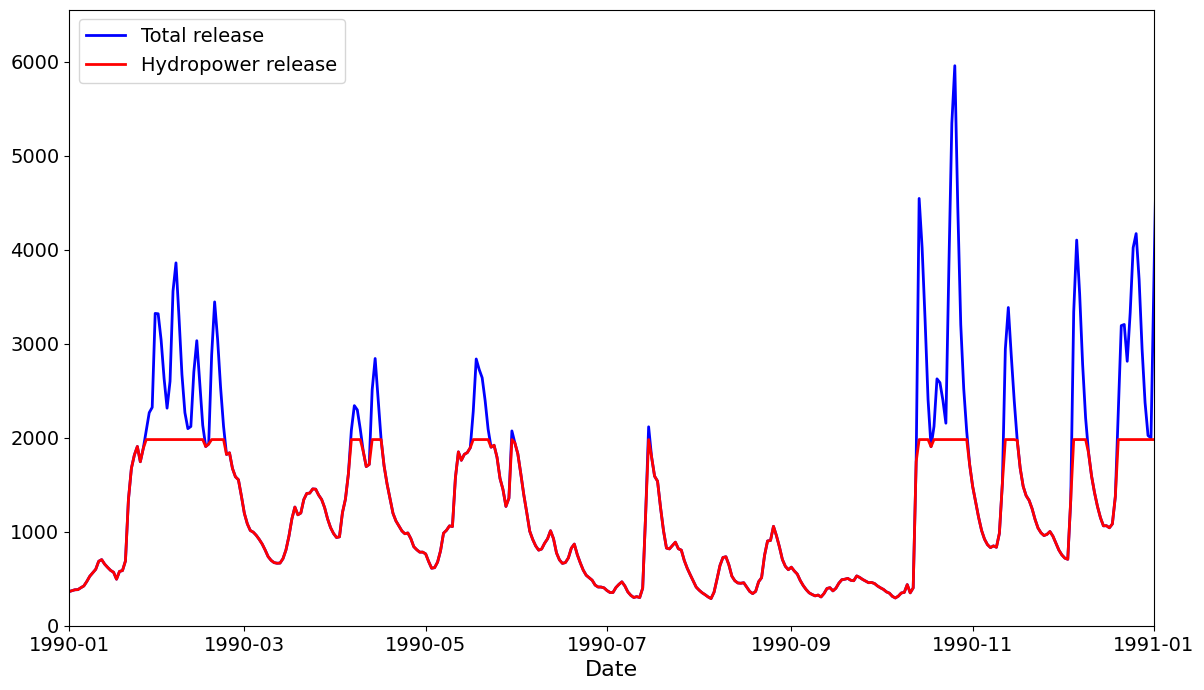

In [6]:
# Let us create a time series of hydropower releases
sop_hp_release = np.minimum(sop_balance['Release (m3/s)'].values, np.ones(len(sop_balance))*conowingo.hydropower_plant.max_release)

# We plot hydropower releases vs. total releases. What do we see?
fig = visuals.compare_flow_timeseries(reference=pd.Series(sop_balance['Release (m3/s)']),
                                      alternative=pd.Series(sop_hp_release, index=sop_balance.index),
                                      labels=['Total release', 'Hydropower release'], 
                                      first_date=datetime.date(1990, 1, 1), 
                                      last_date=datetime.date(1991, 1, 1))

**Question 1. What is the extra release? What does that mean for hydropower production under SOP?**
  

# Part 2: Optimizing hydropower production

Now we try to maximise hydropower production. Let us use a dynamic program to achieve this!

Dynamic programming has two phases. 

First, a backward optimization phase where we go backwards to decompose the problem of finding a release decision over many days into a sequence of single-day decisions. This backward phase yields release decisions for discretised states for every day. 

Second, we use this table of release decisions to find the actual sequence of decisions going forward.

## 2.1 - Dynamic programming

Let us start with the first step, after declaring some key parameters.

In [8]:
# Start date of analysis
first_year = 1989
# Number of discretised storage value
nb_storage_points = 11
# Number of release decisions to investigate at each storage value and time step
nb_decisions = 10

**Question 2. Referring to the code in the `model/dynamic_programming.py` document: what are key steps of the backward optimization algorithm? How long do we run it for? According to you, what would happen if we increased that duration?**

In [10]:
# First we use the backward function to go backward from the final time step to the initial time step.
tables = dynamic_programming.backward_hp_max(reservoir=conowingo, 
                                             water_flows=flows_default, 
                                             first_year=first_year, 
                                             nb_states=nb_storage_points, 
                                             nb_decisions=nb_decisions)

In [11]:
# Let us save the tables to have a look (optional)
pd.DataFrame(tables[0]).to_csv('release.csv')
pd.DataFrame(tables[1]).to_csv('value.csv')

**Question 3. Let us open the CSV files in Excel. What do we see?**

**Question 4. Still referring to code in `model/dynamic_programming.py`, do you understand why we need the forward phase below as a separate phase from the backward optimization?**

In [13]:
# Forward phase
hp_max_balance = dynamic_programming.forward_loop(reservoir=conowingo, 
                                                  water_flows=flows_default, 
                                                  year_beg=first_year, 
                                                  release_table=tables[0])

display(hp_max_balance.head())

,Total inflows (m3/s),Baltimore demand (m3/s),Chester demand (m3/s),Nuclear plant demand (m3/s),Environmental demand (m3/s),Withdrawals Baltimore (m3/s),Withdrawals Chester (m3/s),Withdrawals Nuclear plant (m3/s),Release (m3/s),Storage (m3)
Date,,,,,,,,,,
1989-01-01,575.426640,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,138.960793,3.783944e+08
1989-01-02,554.925243,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,521.107347,3.800000e+08
1989-01-03,583.836743,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,568.602280,3.800000e+08
1989-01-04,568.913765,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,553.679301,3.800000e+08
1989-01-05,467.935890,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,452.701426,3.800000e+08


## 2.2 - Evaluation of optimal policy

Here we look at what the hydropower-maximising policy does and what its consequences are, compared with SOP.

**Question 5. In practice and based on the figures and metrics below, what are the operational consequences of the policy? Its impact on performance?**

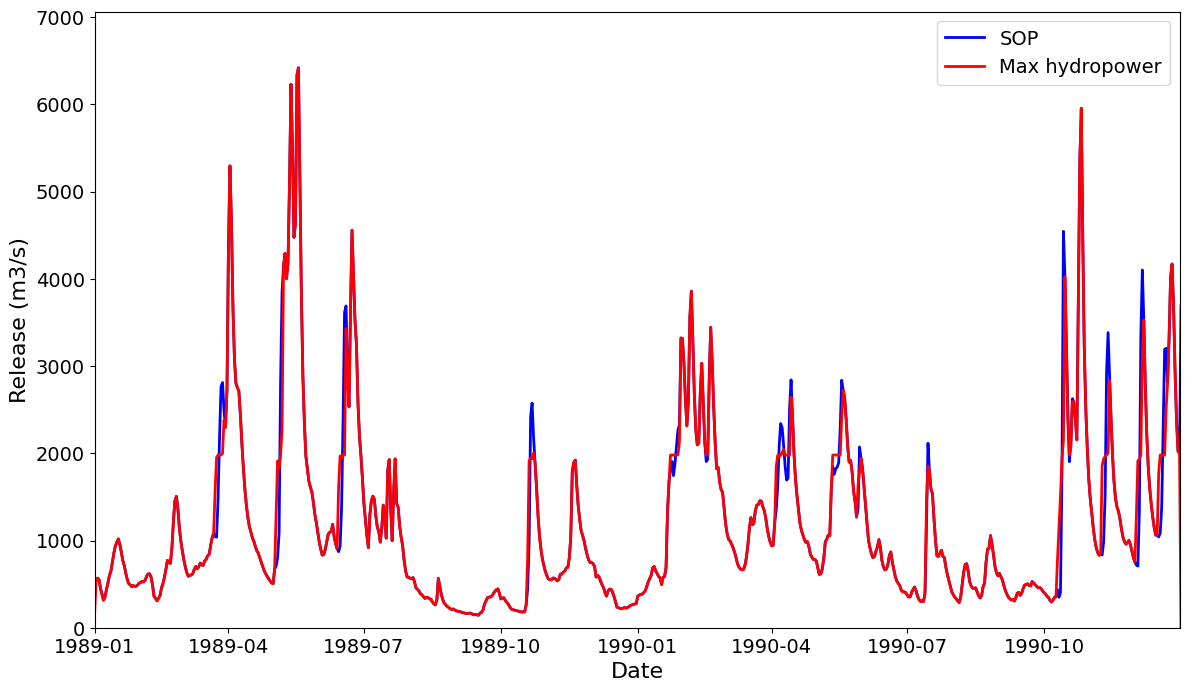

In [15]:
# Comparing releases
fig = visuals.compare_flow_timeseries(reference=pd.Series(sop_balance['Release (m3/s)']),
                                      alternative=pd.Series(hp_max_balance['Release (m3/s)']),
                                      labels=['SOP', 'Max hydropower'], 
                                      first_date=datetime.date(first_year, 1, 1), 
                                      last_date=datetime.date(first_year+1, 12, 31))

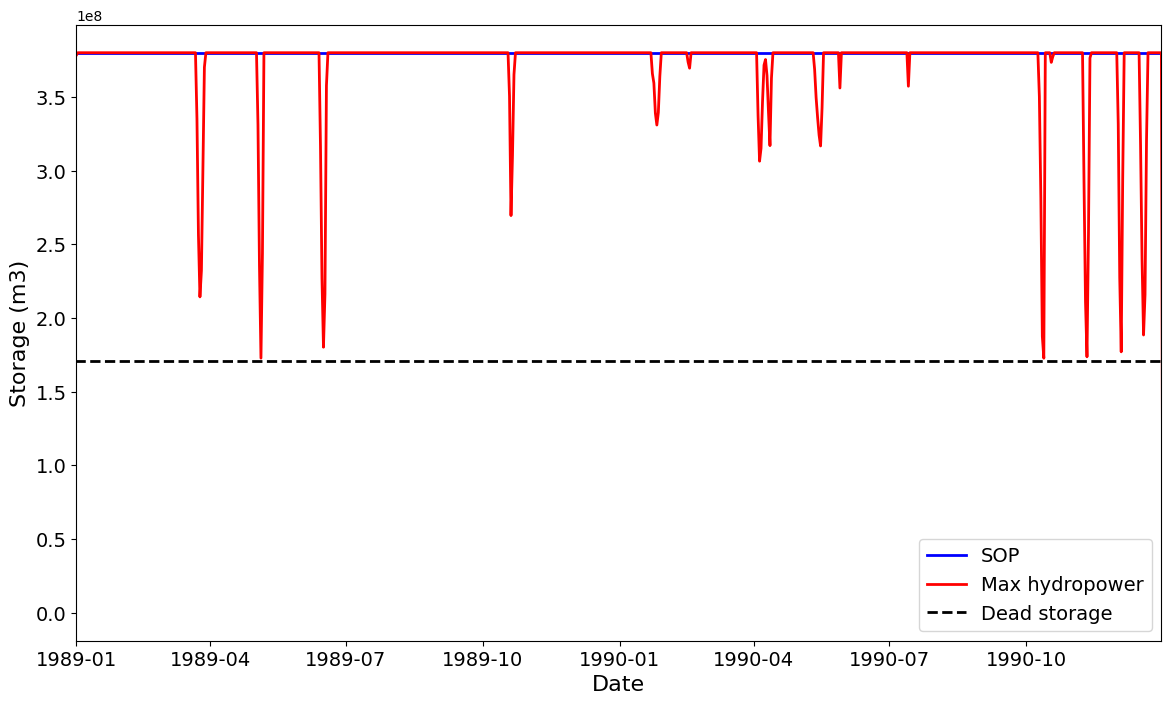

In [16]:
# Comparing storage
fig = visuals.compare_storage_timeseries(reservoir=conowingo, 
                                         storage_1=pd.Series(sop_balance['Storage (m3)']),
                                         storage_2=pd.Series(hp_max_balance['Storage (m3)']),
                                         labels=['SOP', 'Max hydropower'], 
                                         first_date=datetime.date(first_year, 1, 1), 
                                         last_date=datetime.date(first_year+1, 12, 31))

In [17]:
# Performance metrics for SOP
metrics_ref = performance.all_metrics(conowingo, sop_balance.loc[datetime.date(first_year, 1, 1):datetime.date(first_year+1, 12, 31), :])
display(metrics_ref)

,Name,Reliability (0-1),Resilience (-),Vulnerability,Failure count,Volumetric reliability
0,Baltimore,1.0,inf,0,0,1.0
1,Chester,1.0,inf,0,0,1.0
2,Nuclear,1.0,inf,0,0,1.0
3,Env. flows,1.0,inf,0,0,1.0
4,Flooding,1.0,inf,0,0,N/A
5,Recreation,1.0,inf,0,0,N/A


In [18]:
# Performance metrics for the hydropower maximizing policy
metrics_hp_max = performance.all_metrics(conowingo, hp_max_balance.loc[datetime.date(first_year, 1, 1):datetime.date(first_year+1, 12, 31), :])
display(metrics_hp_max)

,Name,Reliability (0-1),Resilience (-),Vulnerability,Failure count,Volumetric reliability
0,Baltimore,0.984932,0.636364,100%,7,0.984932
1,Chester,0.968493,0.347826,100%,8,0.968745
2,Nuclear,0.954795,0.333333,100%,11,0.957117
3,Env. flows,1.0,inf,0,0,1.0
4,Flooding,1.0,inf,0,0,N/A
5,Recreation,0.999068,0.333333,3.00m,2,N/A


In [19]:
# Hydropower production under SOP
daily_hp_ref = conowingo.daily_production(sop_balance)
hp_annual_ref = daily_hp_ref.resample('YE').sum()/1000
hp_ref = hp_annual_ref[hp_annual_ref.index.year==first_year].iloc[0] + hp_annual_ref[hp_annual_ref.index.year==first_year+1].iloc[0]
print('With SOP, ' + str(first_year) + '-' + str(first_year+1) + ' total production is ' + "{:.0f}".format(hp_ref) + ' GWh.')

# Maximised hydropower production
hp_maximised_daily = conowingo.daily_production(hp_max_balance)
hp_annual_max = hp_maximised_daily.resample('YE').sum()/1000
hp_maxi = hp_annual_max[hp_annual_max.index.year==first_year].iloc[0] + hp_annual_max[hp_annual_max.index.year==first_year+1].iloc[0]
print('After hydropower maximisation, ' + str(first_year) + '-' + str(first_year+1) + ' total production is ' + "{:.0f}".format(hp_maxi) + ' GWh.')

# Increase
print('This is a ' + "{:.2f}".format(100*(hp_maxi-hp_ref)/hp_ref) + '% increase with optimization.')

With SOP, 1989-1990 total production is 4862 GWh.
After hydropower maximisation, 1989-1990 total production is 4938 GWh.
This is a 1.55% increase with optimization.


# Part 3: Another optimization

Can we mitigate this tradeoff by constraining that the hydropower maximisation should not empty the reservoir in ways that disrupt water supply. The first user to see its water supply cut when water levels get lower is the nuclear plant.


## 3-1. Dynamic programming setup and execution.

In [21]:
# Success condition: enough water. This corresponds to the demand with the shallowest intake being met (i.e., the Nuclear plant))
# Associated volume
threshold_volume = conowingo.volume_from_height(conowingo.total_lake_depth - conowingo.demand_on_site[2].intake_depth)
print(threshold_volume)

327116301.6421052


In [22]:
# First we use the backward function to go backward from the final time step to the initial time step.
tables_2 = dynamic_programming.backward_hp_max(reservoir=conowingo, 
                                             water_flows=flows_default, 
                                             first_year=first_year, 
                                             nb_states=nb_storage_points, 
                                             nb_decisions=nb_decisions,
                                             threshold_volume=threshold_volume)

# Forward phase
hp_constrained_balance = dynamic_programming.forward_loop(reservoir=conowingo, 
                                                  water_flows=flows_default, 
                                                  year_beg=first_year, 
                                                  release_table=tables_2[0])

display(hp_constrained_balance)

,Total inflows (m3/s),Baltimore demand (m3/s),Chester demand (m3/s),Nuclear plant demand (m3/s),Environmental demand (m3/s),Withdrawals Baltimore (m3/s),Withdrawals Chester (m3/s),Withdrawals Nuclear plant (m3/s),Release (m3/s),Storage (m3)
Date,,,,,,,,,,
1989-01-01,575.426640,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,138.960793,3.783944e+08
1989-01-02,554.925243,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,521.107347,3.800000e+08
1989-01-03,583.836743,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,568.602280,3.800000e+08
1989-01-04,568.913765,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,553.679301,3.800000e+08
1989-01-05,467.935890,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,452.701426,3.800000e+08
...,...,...,...,...,...,...,...,...,...,...
1990-12-28,2959.252053,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,2944.017590,3.800000e+08
1990-12-29,2389.148981,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,2373.914517,3.800000e+08
1990-12-30,2037.963449,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,2022.728986,3.800000e+08


## 3.2 - Policy evaluation

**Question 6. Based on the figures and metrics below, what is the impact on addint constraints, both on policy and on performance?**

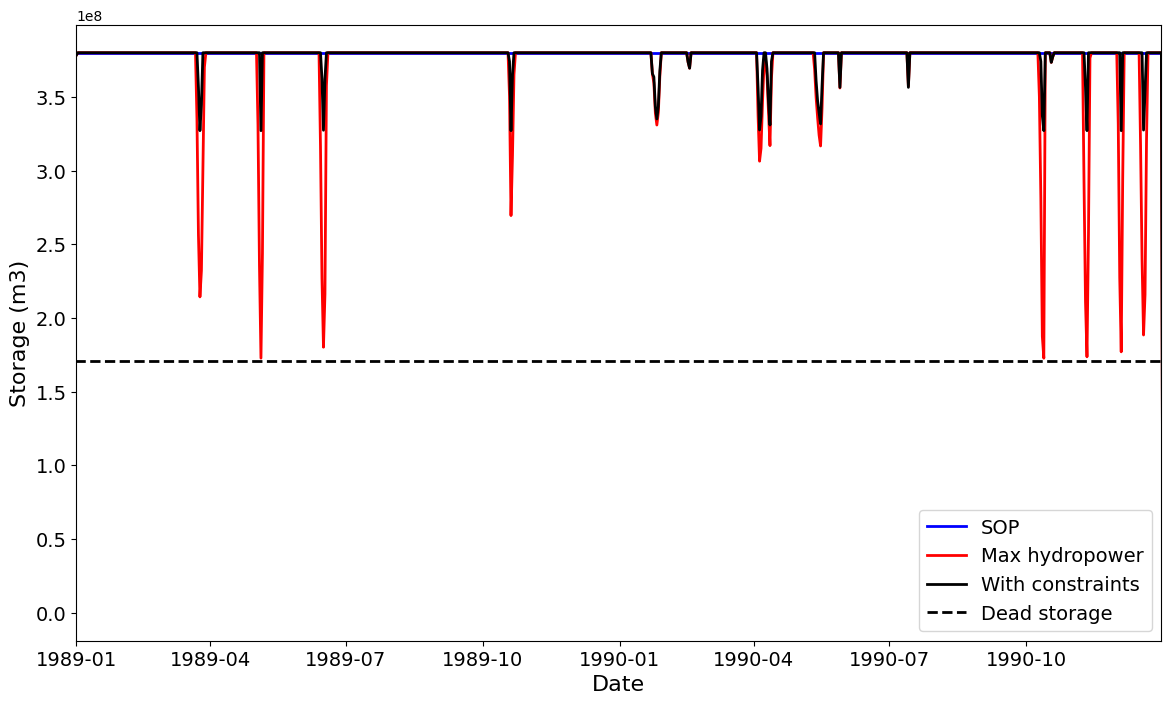

In [24]:
# Storage
fig = visuals.compare_storage_timeseries(reservoir=conowingo, 
                                         storage_1=pd.Series(sop_balance['Storage (m3)']),
                                         storage_2=pd.Series(hp_max_balance['Storage (m3)']),
                                         storage_3=pd.Series(hp_constrained_balance['Storage (m3)']),
                                         labels=['SOP', 'Max hydropower', 'With constraints'], 
                                         first_date=datetime.date(first_year, 1, 1), 
                                         last_date=datetime.date(first_year+1, 12, 31))

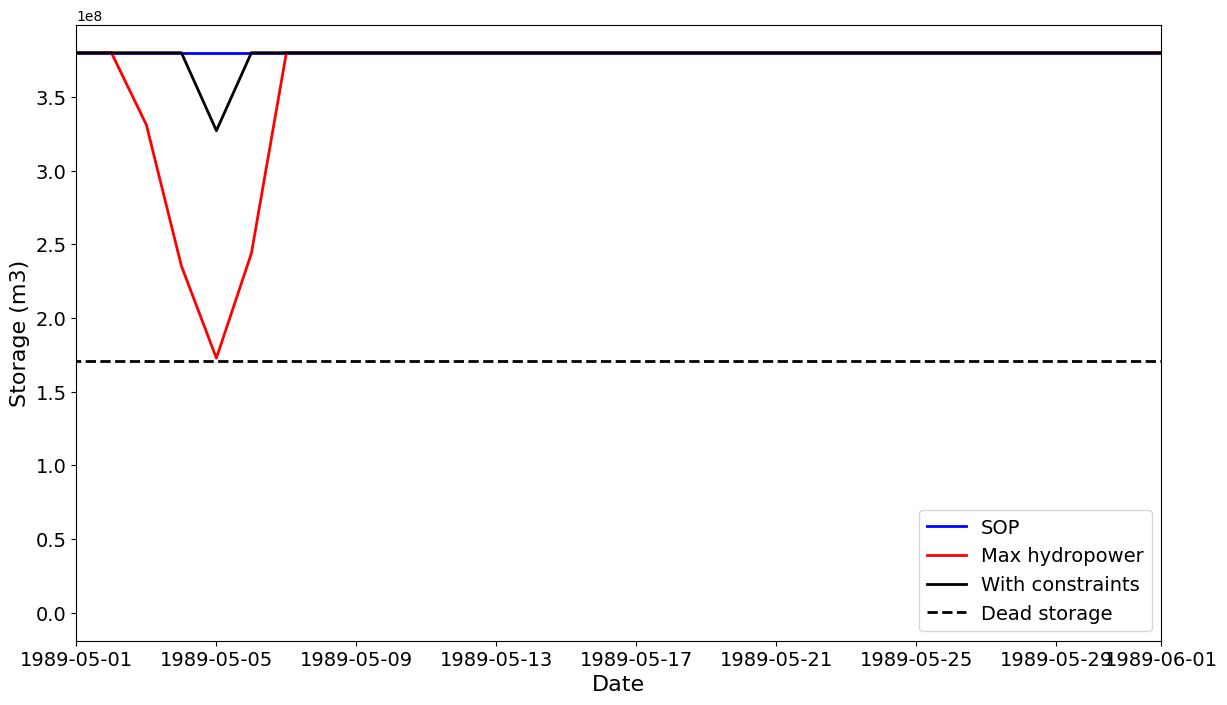

In [25]:
# But what happens? Let's zoom in!
fig = visuals.compare_storage_timeseries(reservoir=conowingo, 
                                         storage_1=pd.Series(sop_balance['Storage (m3)']),
                                         storage_2=pd.Series(hp_max_balance['Storage (m3)']),
                                         storage_3=pd.Series(hp_constrained_balance['Storage (m3)']),
                                         labels=['SOP', 'Max hydropower', 'With constraints'], 
                                         first_date=datetime.date(first_year, 5, 1), 
                                         last_date=datetime.date(first_year, 6, 1))

In [26]:
# Do we get better performance by adding constraints? let's see.
metrics_constrained = performance.all_metrics(conowingo, hp_constrained_balance.loc[datetime.date(first_year, 1, 1):datetime.date(first_year+1, 12, 31), :])
display(metrics_constrained)

,Name,Reliability (0-1),Resilience (-),Vulnerability,Failure count,Volumetric reliability
0,Baltimore,1.0,inf,0,0,1.0
1,Chester,1.0,inf,0,0,1.0
2,Nuclear,1.0,inf,0,0,1.0
3,Env. flows,1.0,inf,0,0,1.0
4,Flooding,1.0,inf,0,0,N/A
5,Recreation,0.999689,1.0,0.48m,2,N/A


In [27]:
# Maximised hydropower production under constraints
hp_constrained_daily = conowingo.daily_production(hp_constrained_balance)
hp_annual_constrained = hp_constrained_daily.resample('YE').sum()/1000
hp_constrained = hp_annual_constrained[hp_annual_constrained.index.year==first_year].iloc[0] + \
                 hp_annual_constrained[hp_annual_constrained.index.year==first_year+1].iloc[0]
print('After hydropower maximisation, ' + str(first_year) + '-' + str(first_year+1) + ' total production is ' + "{:.0f}".format(hp_constrained) + ' GWh.')

# Increase
print('This is a ' + "{:.2f}".format(100*(hp_constrained-hp_ref)/hp_ref) + '% increase with optimization.')

After hydropower maximisation, 1989-1990 total production is 4897 GWh.
This is a 0.70% increase with optimization.


# Part 4: Impact of reservoir size

We have seen that for a reservoir that is small compared with the inflows and uses (i.e., can be filled and emptied in a few days), improvements on SOP to maximise hydropower production are only marginal. But would that be the case with a much larger reservoir?

## 4.1 - Designing a "larger" reservoir

For this we will actually reduce all inflows and demands, including hydropower (i.e., reduce maximum release and installed capacity). This way the storage will look larger compared with its uses. We divide all by 10.

In [29]:
# New flows
rescaled_flows = flows_default.copy()
rescaled_flows = rescaled_flows / 10

# New hydropower use
res_2 = conowingo
res_2.hydropower_plant.installed_capacity = conowingo.hydropower_plant.installed_capacity / 10
res_2.hydropower_plant.max_release = conowingo.hydropower_plant.max_release / 10

## 4.2 - Computing policies in this rescaled setting

Let us compute the three policies that we have examined until now: SOP, and policies maximizing hydropower, without or with constraints.

In [31]:
# Computing the water balance for our standard operating policy (SOP)
sop_rescaled = rescaled_flows.copy()
balance_calcs.sop_full(reservoir=conowingo, water_flows=sop_rescaled)

,Total inflows (m3/s),Baltimore demand (m3/s),Chester demand (m3/s),Nuclear plant demand (m3/s),Environmental demand (m3/s),Withdrawals Baltimore (m3/s),Withdrawals Chester (m3/s),Withdrawals Nuclear plant (m3/s),Release (m3/s),Storage (m3)
Date,,,,,,,,,,
1932-01-01,55.704901,1.313902,0.147248,0.062297,9.910896,1.313902,0.147248,0.062297,9.910896,3.458250e+08
1932-01-02,63.848826,1.313902,0.147248,0.062297,9.910896,1.313902,0.147248,0.062297,9.910896,3.503536e+08
1932-01-03,75.880654,1.313902,0.147248,0.062297,9.910896,1.313902,0.147248,0.062297,9.910896,3.559217e+08
1932-01-04,82.404855,1.313902,0.147248,0.062297,9.910896,1.313902,0.147248,0.062297,9.910896,3.620536e+08
1932-01-05,78.038398,1.313902,0.147248,0.062297,9.910896,1.313902,0.147248,0.062297,9.910896,3.678082e+08
...,...,...,...,...,...,...,...,...,...,...
2001-12-27,77.596655,1.313902,0.144416,0.065129,9.910896,1.313902,0.144416,0.065129,76.073208,3.800000e+08
2001-12-28,71.652949,1.313902,0.144416,0.065129,9.910896,1.313902,0.144416,0.065129,70.129502,3.800000e+08
2001-12-29,66.836253,1.313902,0.144416,0.065129,9.910896,1.313902,0.144416,0.065129,65.312807,3.800000e+08


In [32]:
# Hydropower maximization, no constraints

# First we use the backward function to go backward from the final time step to the initial time step.
tables = dynamic_programming.backward_hp_max(reservoir=res_2, 
                                             water_flows=rescaled_flows, 
                                             first_year=first_year, 
                                             nb_states=nb_storage_points, 
                                             nb_decisions=nb_decisions)

# Forward phase
hp_max_rescaled = dynamic_programming.forward_loop(reservoir=res_2, 
                                                   water_flows=rescaled_flows, 
                                                   year_beg=first_year, 
                                                   release_table=tables[0])

display(hp_max_rescaled.head())

,Total inflows (m3/s),Baltimore demand (m3/s),Chester demand (m3/s),Nuclear plant demand (m3/s),Environmental demand (m3/s),Withdrawals Baltimore (m3/s),Withdrawals Chester (m3/s),Withdrawals Nuclear plant (m3/s),Release (m3/s),Storage (m3)
Date,,,,,,,,,,
1989-01-01,57.542664,1.313902,0.147248,0.062297,9.910896,1.313902,0.147248,0.062297,9.910896,3.459838e+08
1989-01-02,55.492524,1.313902,0.147248,0.062297,9.910896,1.313902,0.147248,0.062297,9.910896,3.497904e+08
1989-01-03,58.383674,1.313902,0.147248,0.062297,9.910896,1.313902,0.147248,0.062297,9.910896,3.538468e+08
1989-01-04,56.891376,1.313902,0.147248,0.062297,9.910896,1.313902,0.147248,0.062297,9.910896,3.577743e+08
1989-01-05,46.793589,1.313902,0.147248,0.062297,9.910896,1.313902,0.147248,0.062297,9.910896,3.608293e+08


In [33]:
# Hydropower maximization, constrained

# First we use the backward function to go backward from the final time step to the initial time step.
tables = dynamic_programming.backward_hp_max(reservoir=res_2, 
                                               water_flows=rescaled_flows, 
                                               first_year=first_year, 
                                               nb_states=nb_storage_points, 
                                               nb_decisions=nb_decisions,
                                               threshold_volume=threshold_volume)

# Forward phase
hp_constrained_rescaled = dynamic_programming.forward_loop(reservoir=res_2, 
                                                           water_flows=rescaled_flows, 
                                                           year_beg=first_year, 
                                                           release_table=tables[0])

display(hp_constrained_rescaled.head())

,Total inflows (m3/s),Baltimore demand (m3/s),Chester demand (m3/s),Nuclear plant demand (m3/s),Environmental demand (m3/s),Withdrawals Baltimore (m3/s),Withdrawals Chester (m3/s),Withdrawals Nuclear plant (m3/s),Release (m3/s),Storage (m3)
Date,,,,,,,,,,
1989-01-01,57.542664,1.313902,0.147248,0.062297,9.910896,1.313902,0.147248,0.062297,9.910896,3.459838e+08
1989-01-02,55.492524,1.313902,0.147248,0.062297,9.910896,1.313902,0.147248,0.062297,9.910896,3.497904e+08
1989-01-03,58.383674,1.313902,0.147248,0.062297,9.910896,1.313902,0.147248,0.062297,9.910896,3.538468e+08
1989-01-04,56.891376,1.313902,0.147248,0.062297,9.910896,1.313902,0.147248,0.062297,9.910896,3.577743e+08
1989-01-05,46.793589,1.313902,0.147248,0.062297,9.910896,1.313902,0.147248,0.062297,9.910896,3.608293e+08


## 4.3 Evaluation

**Question 7. How does storage size influence the benefits of optimization?**

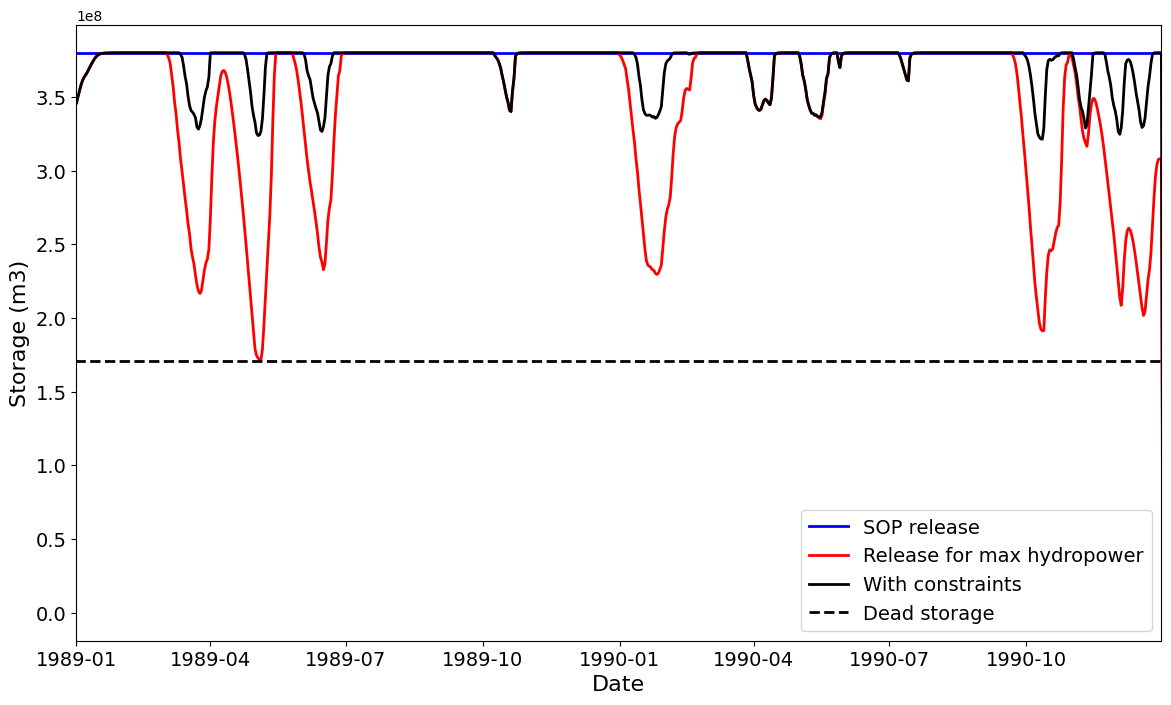

In [35]:
fig = visuals.compare_storage_timeseries(reservoir=res_2, 
                                         storage_1=pd.Series(sop_rescaled['Storage (m3)']),
                                         storage_2=pd.Series(hp_max_rescaled['Storage (m3)']),
                                         storage_3=pd.Series(hp_constrained_rescaled['Storage (m3)']),
                                         labels=['SOP release', 'Release for max hydropower', 'With constraints'], 
                                         first_date=datetime.date(first_year, 1, 1), 
                                         last_date=datetime.date(first_year+1, 12, 31))

In [36]:
m2_sop = performance.all_metrics(res_2, sop_rescaled.loc[datetime.date(first_year, 1, 1):datetime.date(first_year+1, 12, 31), :])
display(m2_sop)

,Name,Reliability (0-1),Resilience (-),Vulnerability,Failure count,Volumetric reliability
0,Baltimore,1.0,inf,0,0,1.0
1,Chester,1.0,inf,0,0,1.0
2,Nuclear,1.0,inf,0,0,1.0
3,Env. flows,1.0,inf,0,0,1.0
4,Flooding,1.0,inf,0,0,N/A
5,Recreation,1.0,inf,0,0,N/A


In [37]:
m2_hpmax = performance.all_metrics(res_2, hp_max_rescaled.loc[datetime.date(first_year, 1, 1):datetime.date(first_year+1, 12, 31), :])
display(m2_hpmax)

,Name,Reliability (0-1),Resilience (-),Vulnerability,Failure count,Volumetric reliability
0,Baltimore,0.965753,0.16,100%,4,0.965753
1,Chester,0.815068,0.044444,100%,6,0.817662
2,Nuclear,0.765753,0.040936,100%,7,0.787942
3,Env. flows,1.0,inf,0,0,1.0
4,Flooding,1.0,inf,0,0,N/A
5,Recreation,0.996118,0.04,3.98m,1,N/A


In [38]:
m2_constrained = performance.all_metrics(res_2, hp_constrained_rescaled.loc[datetime.date(first_year, 1, 1):datetime.date(first_year+1, 12, 31), :])
display(m2_constrained)

,Name,Reliability (0-1),Resilience (-),Vulnerability,Failure count,Volumetric reliability
0,Baltimore,1.0,inf,0,0,1.0
1,Chester,1.0,inf,0,0,1.0
2,Nuclear,0.984932,0.363636,100%,4,0.985358
3,Env. flows,1.0,inf,0,0,1.0
4,Flooding,1.0,inf,0,0,N/A
5,Recreation,0.998292,0.090909,0.93m,1,N/A


In [39]:
# Hydropower production under SOP
daily_hp_ref = res_2.daily_production(sop_rescaled)
hp_annual_ref = daily_hp_ref.resample('YE').sum()/1000
hp_ref = hp_annual_ref[hp_annual_ref.index.year==first_year].iloc[0] + hp_annual_ref[hp_annual_ref.index.year==first_year+1].iloc[0]
print('With SOP, ' + str(first_year) + '-' + str(first_year+1) + ' total production is ' + "{:.0f}".format(hp_ref) + ' GWh.\n')

# Maximised hydropower production
hp_maximised_daily = res_2.daily_production(hp_max_rescaled)
hp_annual_max = hp_maximised_daily.resample('YE').sum()/1000
hp_maxi = hp_annual_max[hp_annual_max.index.year==first_year].iloc[0] + hp_annual_max[hp_annual_max.index.year==first_year+1].iloc[0]
print('After hydropower maximisation, ' + str(first_year) + '-' + str(first_year+1) + ' total production is ' + "{:.0f}".format(hp_maxi) + ' GWh.')
# Increase
print('This is a ' + "{:.2f}".format(100*(hp_maxi-hp_ref)/hp_ref) + '% increase with optimization.\n')

# Maximised hydropower production under constraints
hp_constrained_daily = res_2.daily_production(hp_constrained_rescaled)
hp_annual_constrained = hp_constrained_daily.resample('YE').sum()/1000
hp_constrained = hp_annual_constrained[hp_annual_constrained.index.year==first_year].iloc[0] + \
                 hp_annual_constrained[hp_annual_constrained.index.year==first_year+1].iloc[0]
print('After hydropower maximisation, ' + str(first_year) + '-' + str(first_year+1) + ' total production is ' + "{:.0f}".format(hp_constrained) + ' GWh.')
# Increase
print('This is a ' + "{:.2f}".format(100*(hp_constrained-hp_ref)/hp_ref) + '% increase with optimization.')

With SOP, 1989-1990 total production is 486 GWh.

After hydropower maximisation, 1989-1990 total production is 544 GWh.
This is a 11.95% increase with optimization.

After hydropower maximisation, 1989-1990 total production is 511 GWh.
This is a 5.19% increase with optimization.


Last but not least, you can clean up the CSV files before logging off (especially if working on home machine).